<a href="https://colab.research.google.com/github/tradeasystems/colab_test/blob/master/yahoo_pyfolio_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yahoo Portfolio

In [37]:
!pip install yfinance
!pip install pyfolio

#Restart environment

In [0]:
import pandas as pd
import numpy as np

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Download portfolio from [yahoo](https://es.finance.yahoo.com/portfolios)

In [40]:
#I export yahoo portfolio into this folder in google drive
# my yahoo portfolio has in comments a structure to know exposure to different assets/countries by a dot
# Comment column
portfolio = pd.DataFrame.from_csv('/content/drive/My Drive/Colab Notebooks/quotes.csv')
portfolio.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,Current Price,Date,Time,Change,Open,High,Low,Volume,Trade Date,Purchase Price,Quantity,Commission,High Limit,Low Limit,Comment
Symbol,,,,,,,,,,,,,,,
IAAA.SW,96.41,2019/08/14,09:07 CEST,-0.039993,96.41,96.41,96.41,300,20190813,96.45,10.0,NaN,NaN,NaN,FI.GLOBAL
VID.MC,76.50,2019/08/14,13:22 CEST,-0.800003,77.20,77.20,76.50,954,20190711,79.60,3.0,NaN,NaN,NaN,EQ.EUR
SPY,292.42,2019/08/13,16:00 EDT,4.350006,287.74,294.15,287.36,94792972,20190515,284.95,8.0,NaN,NaN,NaN,EQ.US
SPY,292.42,2019/08/13,16:00 EDT,4.350006,287.74,294.15,287.36,94792972,20190617,290.50,8.0,NaN,NaN,NaN,EQ.US
SPY,292.42,2019/08/13,16:00 EDT,4.350006,287.74,294.15,287.36,94792972,20190711,300.05,7.0,NaN,NaN,NaN,EQ.US


#### Update current price

In [41]:
import yfinance as yf

symbols = set(portfolio.index)
symbols_str = ' '.join(str(e) for e in symbols)
last_data = yf.download(symbols_str)
last_data.tail()

[*********************100%***********************]  3 of 3 downloaded


Adj Close                  Close  ...   Open  Volume                     
             IAAA.SW     SPY VID.MC IAAA.SW  ... VID.MC IAAA.SW         SPY   VID.MC
Date                                         ...                                    
2019-08-16     96.72  288.85   77.9   96.72  ...   76.5  1578.0  83018300.0  17434.0
2019-08-19     96.72  292.33   79.3   96.72  ...   78.5     0.0  53571800.0   9792.0
2019-08-20     96.34  290.09   79.3   96.34  ...   79.0     0.0  51596400.0   5917.0
2019-08-21       NaN  292.45   78.5     NaN  ...   78.1     NaN  49524700.0  10334.0
2019-08-22     96.38     NaN   78.5   96.38  ...   78.4   110.0         NaN     75.0

[5 rows x 18 columns]

In [42]:
updated_current_price = []
last_data['Close'].fillna(method='ffill',inplace=True)
for symbol in portfolio.index:  
  price = last_data['Close'][symbol][-1]
  print('updating price on %s %.3f'%(symbol,price))
  updated_current_price.append(price)
portfolio['Current Price'] = updated_current_price
portfolio.head()

updating price on IAAA.SW 96.380
updating price on VID.MC 78.500
updating price on SPY 292.450
updating price on SPY 292.450
updating price on SPY 292.450
updating price on SPY 292.450


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


,Current Price,Date,Time,Change,Open,High,Low,Volume,Trade Date,Purchase Price,Quantity,Commission,High Limit,Low Limit,Comment
Symbol,,,,,,,,,,,,,,,
IAAA.SW,96.38,2019/08/14,09:07 CEST,-0.039993,96.41,96.41,96.41,300,20190813,96.45,10.0,NaN,NaN,NaN,FI.GLOBAL
VID.MC,78.50,2019/08/14,13:22 CEST,-0.800003,77.20,77.20,76.50,954,20190711,79.60,3.0,NaN,NaN,NaN,EQ.EUR
SPY,292.45,2019/08/13,16:00 EDT,4.350006,287.74,294.15,287.36,94792972,20190515,284.95,8.0,NaN,NaN,NaN,EQ.US
SPY,292.45,2019/08/13,16:00 EDT,4.350006,287.74,294.15,287.36,94792972,20190617,290.50,8.0,NaN,NaN,NaN,EQ.US
SPY,292.45,2019/08/13,16:00 EDT,4.350006,287.74,294.15,287.36,94792972,20190711,300.05,7.0,NaN,NaN,NaN,EQ.US


In [43]:

money_invest = portfolio['Purchase Price']*portfolio['Quantity']

money_invest_total = money_invest.sum()
print('invested %d dollars'%money_invest_total)
money_invest

invested 9345 dollars


Symbol
IAAA.SW     964.50
VID.MC      238.80
SPY        2279.60
SPY        2324.00
SPY        2100.35
SPY        1437.95
dtype: float64

In [44]:
portfolio['open_pnl'] = (portfolio['Current Price']-portfolio['Purchase Price'])*portfolio['Quantity']
print('current pnl %d dollars'%portfolio['open_pnl'].sum())
portfolio['open_pnl']

current pnl 42 dollars


Symbol
IAAA.SW    -0.7
VID.MC     -3.3
SPY        60.0
SPY        15.6
SPY       -53.2
SPY        24.3
Name: open_pnl, dtype: float64

## PnL



In [45]:
#returns
from datetime import datetime
close_historical = last_data['Close']
returns_historical = (last_data['Close']/last_data['Close'].shift(1))-1
start_portfolio = str(min(portfolio['Trade Date']))
start_portfolio
start_portfolio_date = datetime.strptime(start_portfolio, '%Y%m%d').date()
returns_historical = returns_historical[start_portfolio:].fillna(method='ffill')
returns_historical.head()

,IAAA.SW,SPY,VID.MC
Date,,,
2019-05-15,0.000000,0.005857,-0.003628
2019-05-16,0.000434,0.009261,0.008495
2019-05-17,-0.000867,-0.006465,-0.003610
2019-05-20,-0.000759,-0.006612,-0.015700
2019-05-21,0.000000,0.009016,0.009816


In [46]:
#position
position_historical = pd.DataFrame(0,index=returns_historical.index,columns = returns_historical.columns)
for index, row in portfolio.iterrows():
  date_str = str(row['Trade Date'])
  date = datetime.strptime(date_str, '%Y%m%d').date()
  symbol = str(index)
  position = row['Quantity']
  position_historical[symbol][date:] +=position 
position_historical.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,IAAA.SW,SPY,VID.MC
Date,,,
2019-08-16,10.0,28.0,3.0
2019-08-19,10.0,28.0,3.0
2019-08-20,10.0,28.0,3.0
2019-08-21,10.0,28.0,3.0
2019-08-22,10.0,28.0,3.0


#### Historical Pnl


Text(0.5, 1.0, ' open_pnl=0.323 percent  sharpe=0.000087')

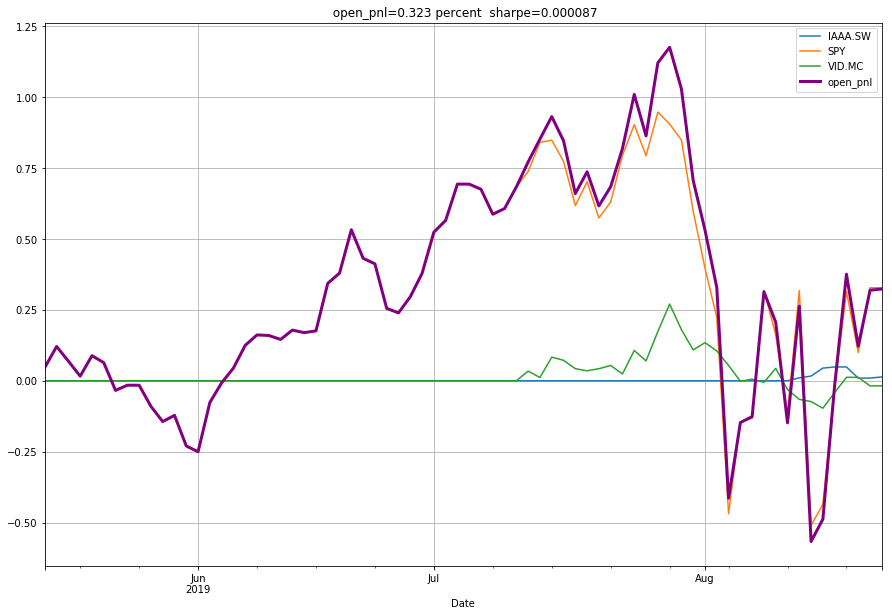

In [47]:
import matplotlib.pyplot as plt
figsize= (15,10)
portfolio_returns = position_historical*returns_historical
portfolio_returns['total'] = portfolio_returns.sum(axis=1)
open_pnl = portfolio_returns.cumsum()
legend=[]
for column in open_pnl.columns:
  if column is not 'total':
    legend.append(column)  
    open_pnl[column].plot(figsize=figsize)
  else:
    legend.append('open_pnl')  
    open_pnl[column].plot(figsize=figsize,color='purple',lw=3)

plt.legend(legend)
plt.grid()

sharpe = (portfolio_returns['total'].mean()/(portfolio_returns['total'].std()*252))

plt.title(' open_pnl=%.3f percent  sharpe=%.6f'%(open_pnl['total'][-1],sharpe))

In [48]:
portfolio_returns['total'].head()

Date
2019-05-15    0.046860
2019-05-16    0.074090
2019-05-17   -0.051721
2019-05-20   -0.052897
2019-05-21    0.072125
Name: total, dtype: float64

#### PyFolio Returns


Start date,2019-05-15
End date,2019-08-22
Total months,3
,Backtest
Annual return,-99.9%
Cumulative returns,-87.2%
Annual volatility,324.9%
Sharpe ratio,0.35
Calmar ratio,-1.03
Stability,0.20
Max drawdown,-97.5%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,97.47,2019-07-29,2019-08-14,NaT,NaN
1,32.50,2019-05-16,2019-06-03,2019-06-13,21
2,29.47,2019-07-15,2019-07-19,2019-07-24,8
3,26.84,2019-06-20,2019-06-26,2019-07-03,10
4,14.64,2019-07-24,2019-07-25,2019-07-26,3


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


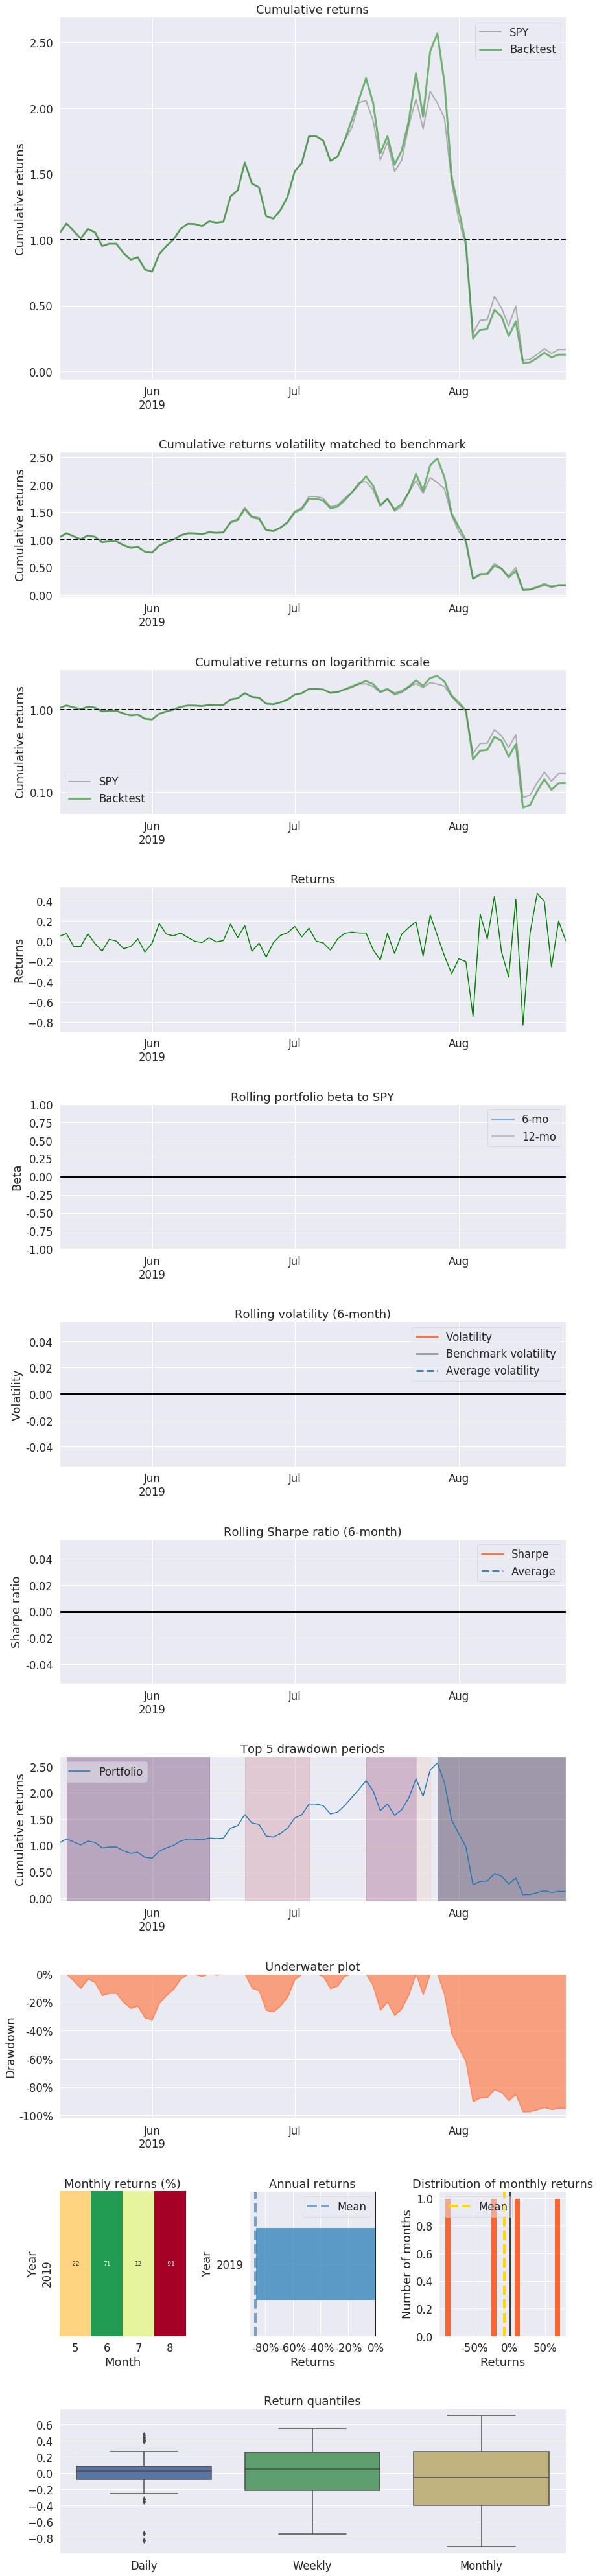

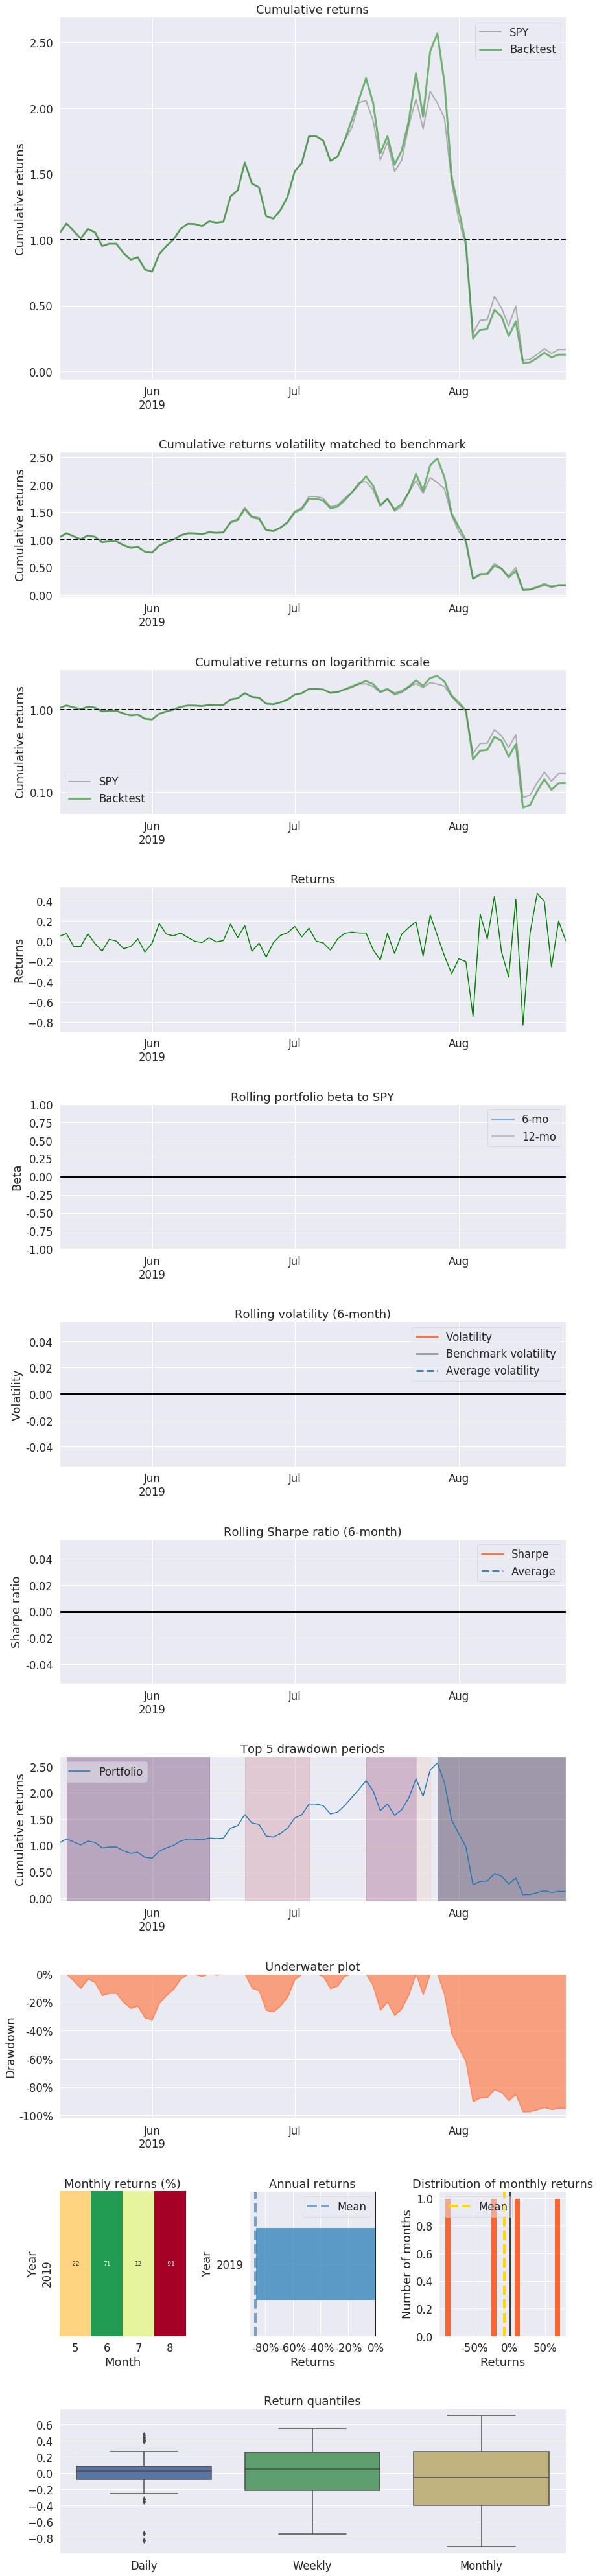

In [49]:
import pyfolio
pyfolio.create_returns_tear_sheet(portfolio_returns['total'],benchmark_rets=portfolio_returns['SPY'], return_fig=True)

##Portfolio exp
Remember that comments in yahoo need to have format
 %asset_type%.%country%

In [50]:
portfolio["asset_class"] = portfolio["Comment"]
portfolio["geography"] = portfolio["Comment"]
portfolio[['asset_class','geography']] = portfolio['Comment'].str.split('.',expand=True)
portfolio['position_pct'] = (portfolio['Current Price']*portfolio['Quantity'])/ (portfolio['Current Price']*portfolio['Quantity']).sum()
portfolio.head()

,Current Price,Date,Time,Change,Open,High,Low,Volume,Trade Date,Purchase Price,Quantity,Commission,High Limit,Low Limit,Comment,open_pnl,asset_class,geography,position_pct
Symbol,,,,,,,,,,,,,,,,,,,
IAAA.SW,96.38,2019/08/14,09:07 CEST,-0.039993,96.41,96.41,96.41,300,20190813,96.45,10.0,NaN,NaN,NaN,FI.GLOBAL,-0.7,FI,GLOBAL,0.102664
VID.MC,78.50,2019/08/14,13:22 CEST,-0.800003,77.20,77.20,76.50,954,20190711,79.60,3.0,NaN,NaN,NaN,EQ.EUR,-3.3,EQ,EUR,0.025085
SPY,292.45,2019/08/13,16:00 EDT,4.350006,287.74,294.15,287.36,94792972,20190515,284.95,8.0,NaN,NaN,NaN,EQ.US,60.0,EQ,US,0.249214
SPY,292.45,2019/08/13,16:00 EDT,4.350006,287.74,294.15,287.36,94792972,20190617,290.50,8.0,NaN,NaN,NaN,EQ.US,15.6,EQ,US,0.249214
SPY,292.45,2019/08/13,16:00 EDT,4.350006,287.74,294.15,287.36,94792972,20190711,300.05,7.0,NaN,NaN,NaN,EQ.US,-53.2,EQ,US,0.218063


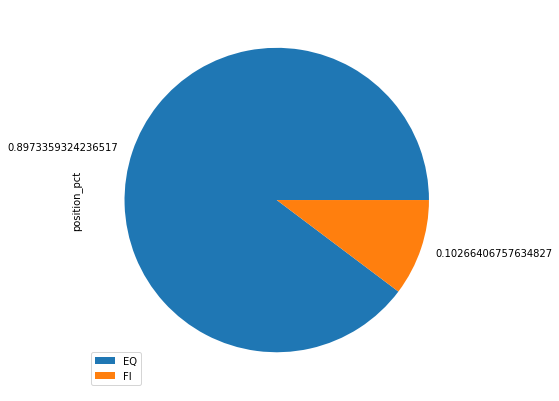

In [60]:
labels = portfolio.groupby('asset_class').sum()['position_pct']
portfolio.groupby('asset_class').sum()['position_pct'].plot.pie(y='position_pct', figsize=(7, 7),labels= labels)
plt.legend(portfolio.groupby('asset_class').sum().index,loc=3)

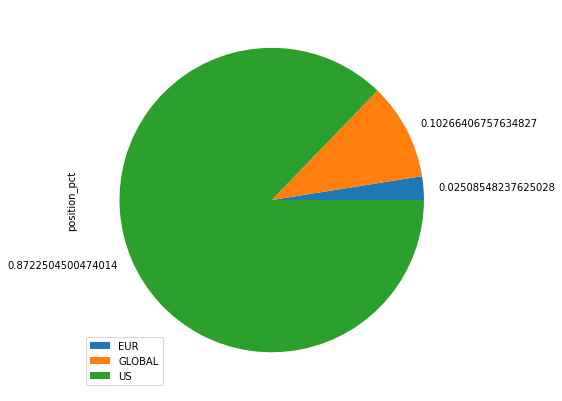

In [61]:
labels = portfolio.groupby('geography').sum()['position_pct']
portfolio.groupby('geography').sum()['position_pct'].plot.pie(y='position_pct', figsize=(7, 7),labels= labels)
plt.legend(portfolio.groupby('geography').sum().index,loc=3)